<a href="https://colab.research.google.com/github/ktakanov/analise-e-previsao-de-cargo/blob/master/An%C3%A1lise_e_previs%C3%A3o_de_promo%C3%A7%C3%A3o_de_cargo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Leitura do dataset

## train

In [2]:
import pandas as pd

df = pd.read_csv("train.csv")
df

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1.0,35.0,5.0,8.0,1.0,0.0,49.0,0.0
1,65141,Operations,region_22,Bachelor's,m,other,1.0,30.0,5.0,4.0,0.0,0.0,60.0,0.0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1.0,34.0,3.0,7.0,0.0,0.0,50.0,0.0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2.0,39.0,1.0,10.0,0.0,0.0,50.0,0.0
4,48945,Technology,region_26,Bachelor's,m,other,1.0,45.0,3.0,2.0,0.0,0.0,73.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15289,5987,Operations,region_22,Master's & above,m,sourcing,2.0,38.0,2.0,10.0,0.0,0.0,55.0,0.0
15290,55123,Operations,region_19,Bachelor's,m,other,1.0,40.0,3.0,5.0,1.0,0.0,57.0,1.0
15291,15654,Sales & Marketing,region_2,Bachelor's,f,other,1.0,35.0,4.0,8.0,0.0,0.0,43.0,0.0
15292,27822,Operations,region_4,Master's & above,f,other,1.0,38.0,5.0,10.0,1.0,0.0,59.0,0.0


In [3]:
new_cols = ["employee_id" ,"department" ,"region" ,"education" ,"gender" ,"recruitment_channel" ,"no_of_trainings" ,"age" ,"previous_year_rating" ,"service_time" ,"good_performance" ,"awards_won" ,"avg_training_score" ,"is_promoted"]

In [4]:
df.columns = new_cols
df.head(2)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,service_time,good_performance,awards_won,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1.0,35.0,5.0,8.0,1.0,0.0,49.0,0.0
1,65141,Operations,region_22,Bachelor's,m,other,1.0,30.0,5.0,4.0,0.0,0.0,60.0,0.0


In [5]:
import random
import numpy as np
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [6]:
print(train.shape)
print(test.shape)

(12235, 14)
(3059, 14)


# Processamento de Dados

## Removendo dados nulos

In [7]:
train.isna().sum()

employee_id               0
department                0
region                    0
education               558
gender                    0
recruitment_channel       0
no_of_trainings           0
age                       0
previous_year_rating    924
service_time              0
good_performance          0
awards_won                0
avg_training_score        0
is_promoted               0
dtype: int64

### Visualização de linhas vazias por colunas

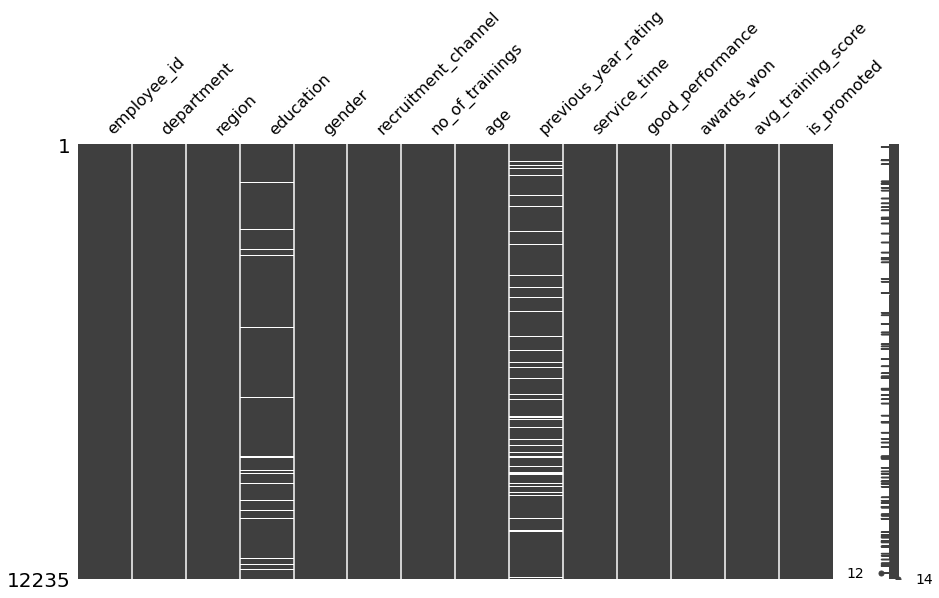

In [8]:
import missingno as msno
msno.matrix(train, figsize=(15,8))

In [9]:
total_rows = train.shape[0]
train = train.dropna()
print("Removed rows: ", total_rows - train.shape[0])

Removed rows:  1390


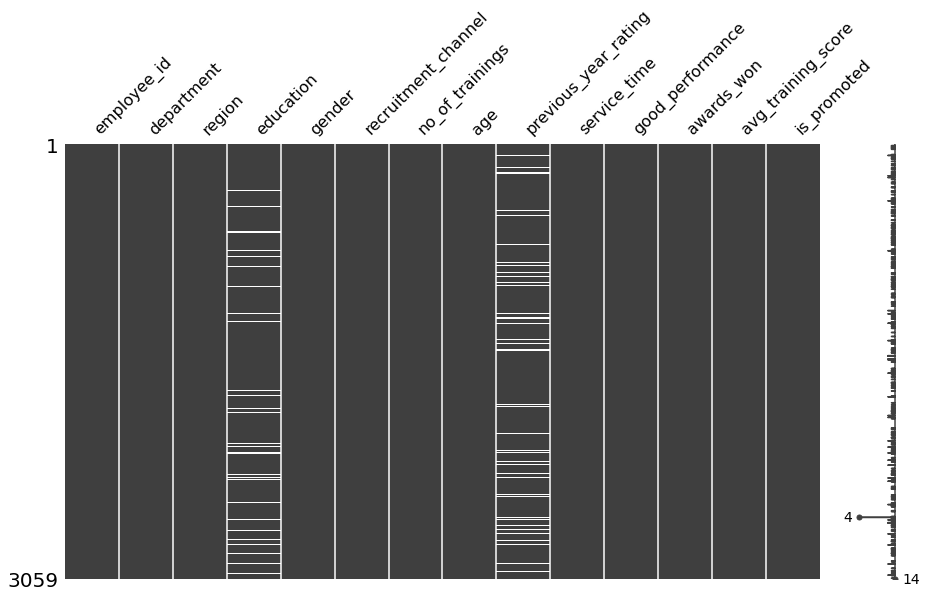

In [10]:
msno.matrix(test, figsize=(15,8))

In [11]:
total_rows = test.shape[0]
test = test.dropna()
print("Removed rows: ", total_rows - test.shape[0])

Removed rows:  349


# Exploração de Dados

## Distribuição do dataset


## Os labels estão desbalanceados?

- Nesta seção descreve-se a distribuição das promoções que encontra-se em apenas cerca de 3% para promovidos.

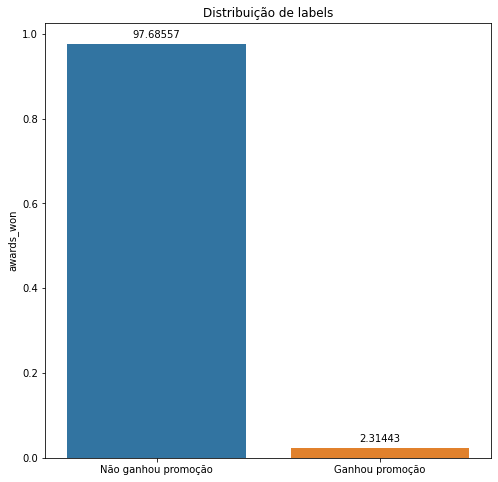

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.title("Distribuição de labels")
aux = train.awards_won.value_counts(normalize=True).reset_index()
splot = sns.barplot(data=aux,x=["Não ganhou promoção","Ganhou promoção"],y='awards_won')

for p in splot.patches:
    splot.annotate(format(p.get_height() * 100, '.5f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

### Features categóricas
- Como esta distribuido os funcionarios de acordo com o departamento, grau de educacao, idade e genero da empresa?



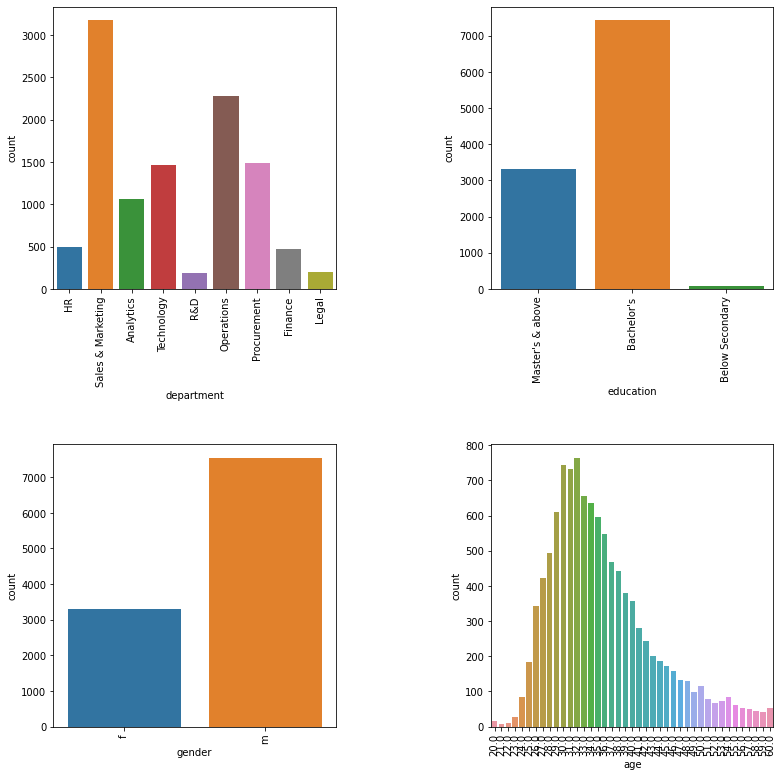

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
fig.tight_layout()
i=0
for column in ['department','education','gender','age']:
    g = sns.countplot(ax=axes[i//2,i%2],data=train,x=column)
    plt.subplots_adjust(left=0, bottom=0, right=0.5, top=0.5, wspace=0.55, hspace=0.55)
    g.set_xticklabels(g.get_xticklabels(),rotation=90)
    i+=1

- Agora que sabemos a distribuição, podemos verificar se há alguma relaçao com a promoção no trabalho.

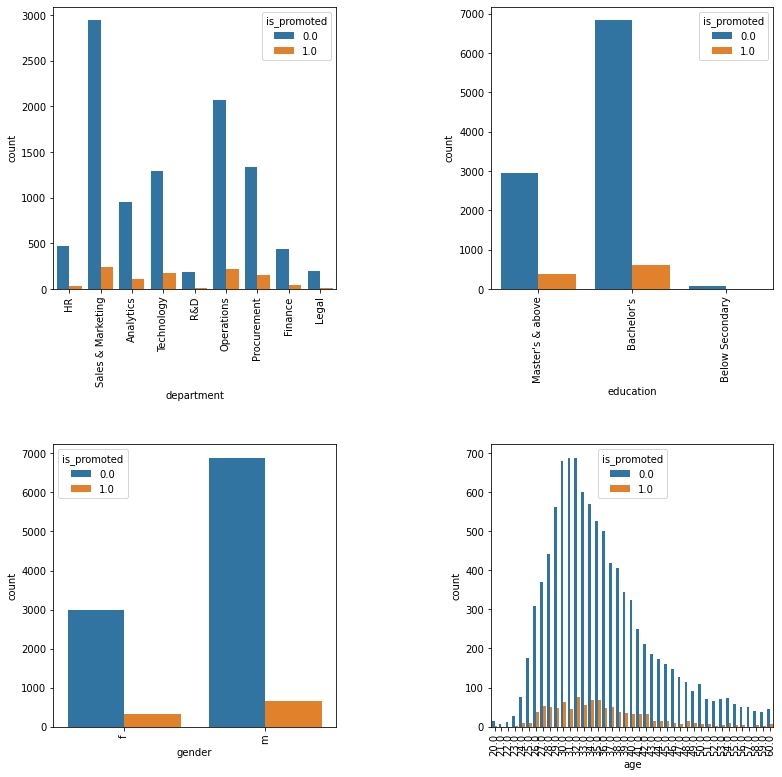

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
fig.tight_layout()
i=0
for column in ['department','education','gender','age']:
    g = sns.countplot(ax=axes[i//2,i%2],data=train,x=column, hue ='is_promoted')
    plt.subplots_adjust(left=0, bottom=0, right=0.5, top=0.5, wspace=0.55, hspace=0.55)
    g.set_xticklabels(g.get_xticklabels(),rotation=90)
    i+=1

## Plot 2 a 2 de features

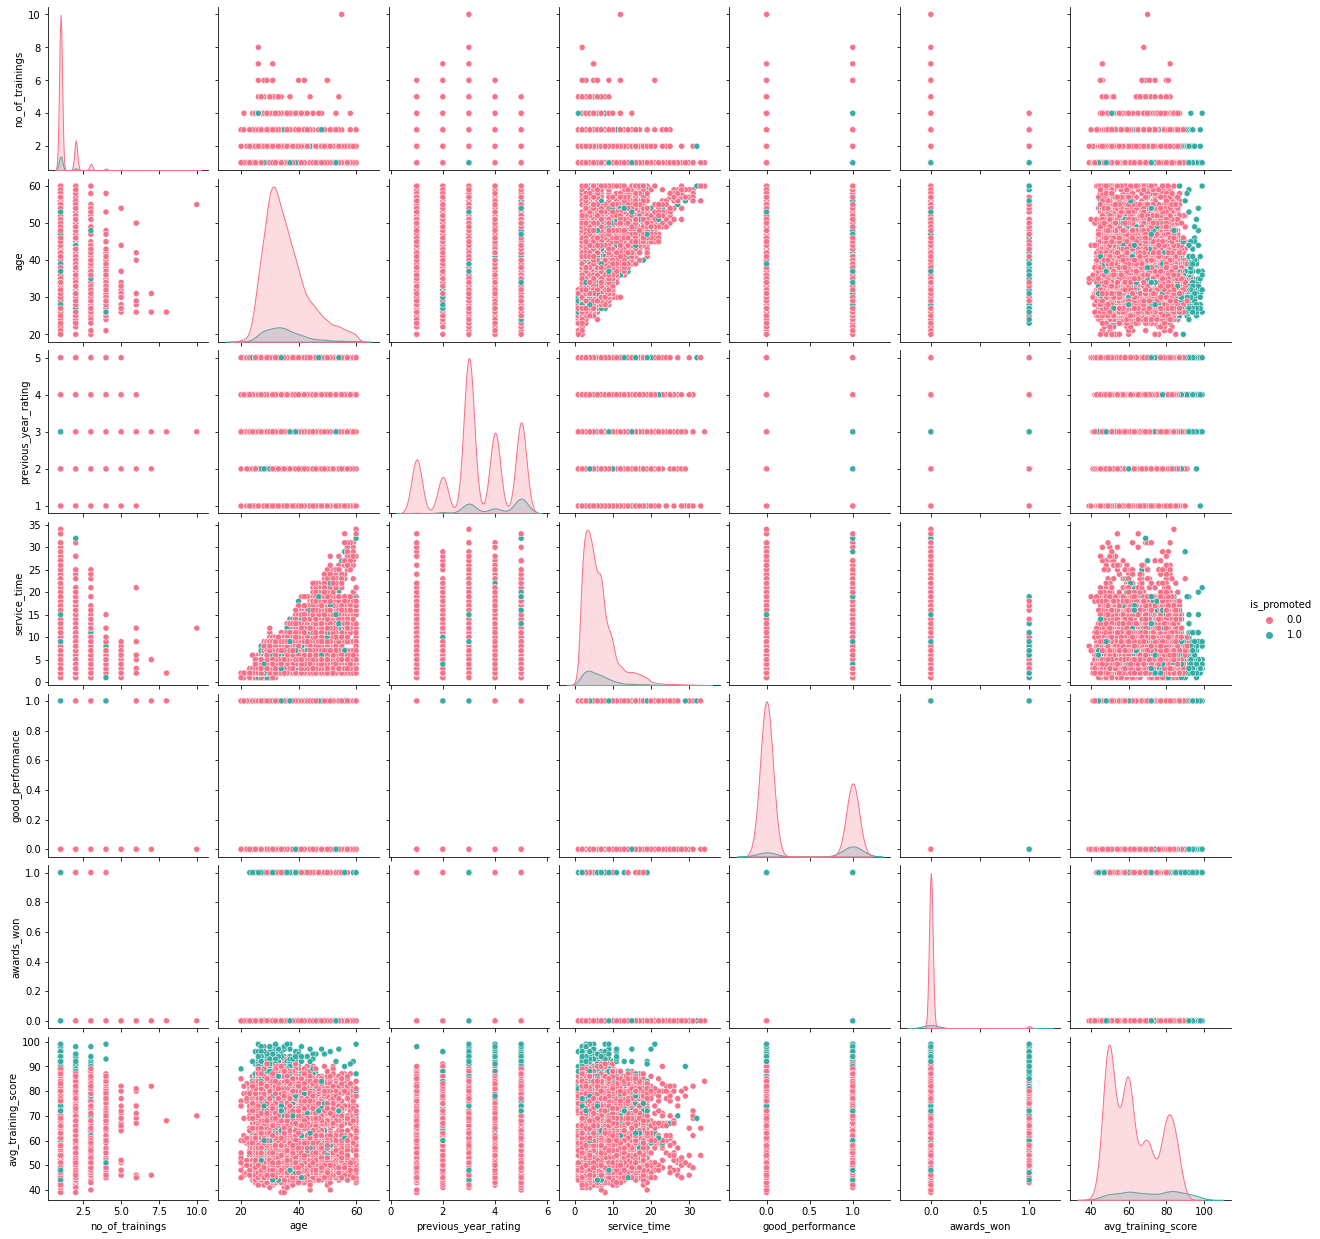

In [15]:
sns.pairplot(train[train.columns[1:]], hue="is_promoted", palette="husl")

## Relação de features numéricas

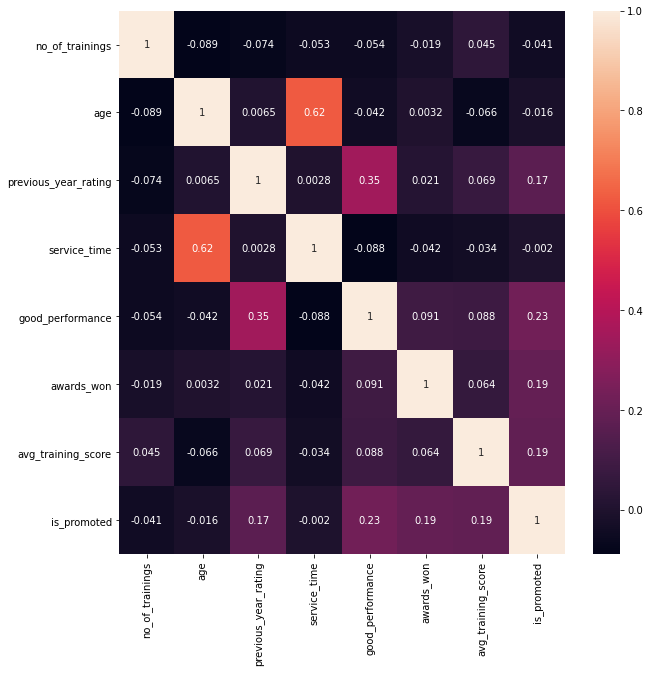

In [16]:
plt.figure(figsize = (10,10))
sns.heatmap(train[list(train)[1:]].corr(), annot=True)

## Remoção de coluns indesejadas

- Através da relação acima, é possível perceber as colunas no_of_trainings, age e no_of_trainings não ajuda muito na promoção do cargo.

In [17]:
train = train.drop(['no_of_trainings', 'age', 'service_time'],axis=1)
train.head()

,employee_id,department,region,education,gender,recruitment_channel,previous_year_rating,good_performance,awards_won,avg_training_score,is_promoted
13066,63875,HR,region_27,Master's & above,f,other,5.0,1.0,0.0,47.0,0.0
5055,22736,Sales & Marketing,region_4,Master's & above,m,sourcing,5.0,0.0,0.0,62.0,1.0
5019,42262,Analytics,region_34,Bachelor's,m,sourcing,4.0,1.0,0.0,81.0,0.0
4899,9997,Sales & Marketing,region_13,Bachelor's,f,other,3.0,0.0,0.0,53.0,0.0
11300,53791,Technology,region_2,Master's & above,f,sourcing,4.0,1.0,0.0,84.0,0.0


- Devemos remover no teste também.

In [18]:
test = test.drop(['no_of_trainings', 'age', 'service_time'],axis=1)
test.head()

,employee_id,department,region,education,gender,recruitment_channel,previous_year_rating,good_performance,awards_won,avg_training_score,is_promoted
9225,26605,Legal,region_32,Bachelor's,m,other,2.0,0.0,0.0,60.0,0.0
1367,35067,Technology,region_2,Below Secondary,m,sourcing,3.0,0.0,0.0,81.0,0.0
11465,28499,Technology,region_2,Master's & above,m,other,3.0,0.0,0.0,76.0,0.0
747,69847,Operations,region_26,Bachelor's,f,other,4.0,1.0,0.0,59.0,0.0
7317,68646,Procurement,region_8,Bachelor's,m,other,3.0,1.0,0.0,68.0,0.0


# Construção de Entrada 

## Remoção de ID do empregado

In [19]:
# removing the employee_id column

train = train.drop(['employee_id'], axis = 1)

train.columns

Index(['department', 'region', 'education', 'gender', 'recruitment_channel',
       'previous_year_rating', 'good_performance', 'awards_won',
       'avg_training_score', 'is_promoted'],
      dtype='object')

In [20]:
test = test.drop(['employee_id'], axis = 1)
test.head(2)

,department,region,education,gender,recruitment_channel,previous_year_rating,good_performance,awards_won,avg_training_score,is_promoted
9225,Legal,region_32,Bachelor's,m,other,2.0,0.0,0.0,60.0,0.0
1367,Technology,region_2,Below Secondary,m,sourcing,3.0,0.0,0.0,81.0,0.0


## Order columns

In [21]:
order_cols = ["department" ,"region" ,"education" ,"gender" ,"recruitment_channel" ,"previous_year_rating" ,"good_performance" ,"awards_won" ,"avg_training_score" ,"is_promoted"]


In [22]:
train = train[order_cols]
test = test[order_cols]

## Transform data to one-hot

In [23]:
test

,department,region,education,gender,recruitment_channel,previous_year_rating,good_performance,awards_won,avg_training_score,is_promoted
9225,Legal,region_32,Bachelor's,m,other,2.0,0.0,0.0,60.0,0.0
1367,Technology,region_2,Below Secondary,m,sourcing,3.0,0.0,0.0,81.0,0.0
11465,Technology,region_2,Master's & above,m,other,3.0,0.0,0.0,76.0,0.0
747,Operations,region_26,Bachelor's,f,other,4.0,1.0,0.0,59.0,0.0
7317,Procurement,region_8,Bachelor's,m,other,3.0,1.0,0.0,68.0,0.0
...,...,...,...,...,...,...,...,...,...,...
769,Technology,region_22,Bachelor's,m,referred,4.0,1.0,0.0,84.0,0.0
5244,Procurement,region_26,Bachelor's,m,other,3.0,0.0,0.0,70.0,0.0
12713,Sales & Marketing,region_7,Bachelor's,m,other,3.0,1.0,0.0,99.0,1.0
5698,Operations,region_33,Bachelor's,m,other,3.0,1.0,1.0,60.0,0.0


In [24]:
X_test = pd.get_dummies(test)

X_test = pd.get_dummies(test.iloc[:,:-1])
y_test = (test.iloc[:,-1])

print(X_test)
print(y_test)

       previous_year_rating  ...  recruitment_channel_sourcing
9225                    2.0  ...                             0
1367                    3.0  ...                             1
11465                   3.0  ...                             0
747                     4.0  ...                             0
7317                    3.0  ...                             0
...                     ...  ...                           ...
769                     4.0  ...                             0
5244                    3.0  ...                             0
12713                   3.0  ...                             0
5698                    3.0  ...                             0
4445                    5.0  ...                             0

[2710 rows x 55 columns]
9225     0.0
1367     0.0
11465    0.0
747      0.0
7317     0.0
        ... 
769      0.0
5244     0.0
12713    1.0
5698     0.0
4445     0.0
Name: is_promoted, Length: 2710, dtype: float64


In [25]:
X_train = pd.get_dummies(test)

X_train = pd.get_dummies(train.iloc[:,:-1])
y_train = (train.iloc[:,-1])

print(X_train)
print(y_train)

       previous_year_rating  ...  recruitment_channel_sourcing
13066                   5.0  ...                             0
5055                    5.0  ...                             1
5019                    4.0  ...                             1
4899                    3.0  ...                             0
11300                   4.0  ...                             1
...                     ...  ...                           ...
2512                    4.0  ...                             1
11503                   5.0  ...                             1
12766                   1.0  ...                             0
13040                   5.0  ...                             0
10503                   3.0  ...                             0

[10845 rows x 55 columns]
13066    0.0
5055     1.0
5019     0.0
4899     0.0
11300    0.0
        ... 
2512     0.0
11503    0.0
12766    0.0
13040    0.0
10503    1.0
Name: is_promoted, Length: 10845, dtype: float64


## Scale data

In [26]:
train._get_numeric_data()

,previous_year_rating,good_performance,awards_won,avg_training_score,is_promoted
13066,5.0,1.0,0.0,47.0,0.0
5055,5.0,0.0,0.0,62.0,1.0
5019,4.0,1.0,0.0,81.0,0.0
4899,3.0,0.0,0.0,53.0,0.0
11300,4.0,1.0,0.0,84.0,0.0
...,...,...,...,...,...
2512,4.0,0.0,0.0,54.0,0.0
11503,5.0,1.0,0.0,58.0,0.0
12766,1.0,0.0,0.0,66.0,0.0
13040,5.0,1.0,0.0,82.0,0.0


In [27]:

from sklearn.preprocessing import StandardScaler

X_train._get_numeric_data()

,previous_year_rating,good_performance,awards_won,avg_training_score,department_Analytics,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,region_region_1,region_region_10,region_region_11,region_region_12,region_region_13,region_region_14,region_region_15,region_region_16,region_region_17,region_region_18,region_region_19,region_region_2,region_region_20,region_region_21,region_region_22,region_region_23,region_region_24,region_region_25,region_region_26,region_region_27,region_region_28,region_region_29,region_region_3,region_region_30,region_region_31,region_region_32,region_region_33,region_region_34,region_region_4,region_region_5,region_region_6,region_region_7,region_region_8,region_region_9,education_Bachelor's,education_Below Secondary,education_Master's & above,gender_f,gender_m,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing
13066,5.0,1.0,0.0,47.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0
5055,5.0,0.0,0.0,62.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1
5019,4.0,1.0,0.0,81.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1
4899,3.0,0.0,0.0,53.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0
11300,4.0,1.0,0.0,84.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,4.0,0.0,0.0,54.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1
11503,5.0,1.0,0.0,58.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1
12766,1.0,0.0,0.0,66.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0
13040,5.0,1.0,0.0,82.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0


# Tratando desbalanceamento

In [28]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print("Dados antes do SMOTE: ", X_train.shape[0])

x_sample, y_sample = SMOTE().fit_sample(X_train, y_train)

x_sample = pd.DataFrame(x_sample)
y_sample = pd.DataFrame(y_sample)

unique, counts = np.unique(y_sample, return_counts=True)
dist = dict(zip(unique, counts))

print("Tamanho da amostra depois:", x_sample.shape)
print("Distribuição final de y_sample:", dist)



/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Dados antes do SMOTE:  10845
Tamanho da amostra depois: (19742, 55)
Distribuição final de y_sample: {0.0: 9871, 1.0: 9871}


In [ ]:
X_train.shape

(21677, 55)

# Split into Train and Valid

In [29]:
# splitting x and y into train and validation sets

from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_sample, y_sample, test_size = 0.2, random_state = 0)

print("Tamanho de x_train: ", x_train.shape)
print("Tamanho de x_valid: ", x_valid.shape)
print("Tamanho de y_train: ", y_train.shape)
print("Tamanho de y_valid: ", y_valid.shape)


Tamanho de x_train:  (15793, 55)
Tamanho de x_valid:  (3949, 55)
Tamanho de y_train:  (15793, 1)
Tamanho de y_valid:  (3949, 1)


# Normalizando a entrada

In [30]:
# standard scaling

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test  = sc.transform(X_test)
x_valid = sc.transform(x_valid)

# Construção de modelo, otimização de entrada e previsão final

In [48]:
from sklearn.ensemble import RandomForestClassifier
def test_valid(X, y, X_valid, y_valid, n_estimators=200,
               max_features='auto', min_samples_leaf=1):
    rf = RandomForestClassifier(n_estimators=n_estimators,
                               n_jobs=-1,
                               oob_score=True,
                               max_features=max_features, 
                               min_samples_leaf=min_samples_leaf)
    rf.fit(X, y)
    train_acc =  rf.score(x_train, y_train)
    print("Training Accuracy :", train_acc)
    valid_acc = rf.score(x_valid, y_valid)
    print("Valid Accuracy :", valid_acc)
    return rf, train_acc, valid_acc

In [50]:
train_accs = []
valid_accs = []

best_acc = 0
best_rf = None
ntrees = 200
minleaf = 1
maxf = .3
for minleaf in range(1,3*10,3):
  print(f"n_estimators={ntrees}, max_features={maxf}, min_samples_leaf={minleaf}")
  rf, train_acc, valid_acc = test_valid(x_train, y_train, x_valid, y_valid,
            max_features=maxf, min_samples_leaf=minleaf)

  train_accs.append(train_acc)
  valid_accs.append(valid_acc)
  if valid_acc > best_acc:
    best_rf = rf

n_estimators=200, max_features=0.3, min_samples_leaf=1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Training Accuracy : 0.995947571708985
Valid Accuracy : 0.9577108128640162
n_estimators=200, max_features=0.3, min_samples_leaf=4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Training Accuracy : 0.9749889191413917
Valid Accuracy : 0.9559382122056217
n_estimators=200, max_features=0.3, min_samples_leaf=7


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Training Accuracy : 0.9692901918571519
Valid Accuracy : 0.951126867561408
n_estimators=200, max_features=0.3, min_samples_leaf=10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Training Accuracy : 0.9622617615399227
Valid Accuracy : 0.9442896935933147
n_estimators=200, max_features=0.3, min_samples_leaf=13


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Training Accuracy : 0.9584626100170962
Valid Accuracy : 0.9422638642694353
n_estimators=200, max_features=0.3, min_samples_leaf=16


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Training Accuracy : 0.9517507756601026
Valid Accuracy : 0.9349202329703723
n_estimators=200, max_features=0.3, min_samples_leaf=19


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Training Accuracy : 0.9483315392895587
Valid Accuracy : 0.9313750316535832
n_estimators=200, max_features=0.3, min_samples_leaf=22


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Training Accuracy : 0.9420629392768948
Valid Accuracy : 0.9273233730058242
n_estimators=200, max_features=0.3, min_samples_leaf=25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Training Accuracy : 0.9414930665484709
Valid Accuracy : 0.9250443150164599
n_estimators=200, max_features=0.3, min_samples_leaf=28


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Training Accuracy : 0.9366174887608434
Valid Accuracy : 0.9235249430235503


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Iteracoes vs Acurácia')

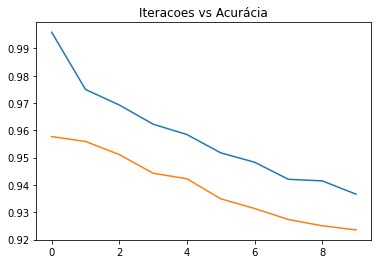

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.lineplot(range(0,len(train_accs)), train_accs)
sns.lineplot(range(0,len(valid_accs)), valid_accs)

plt.title("Iteracoes vs Acurácia")

In [45]:
print("Test Accuracy :", rf.score(x_test, y_test))

Test Accuracy : 0.9173431734317343
